# Finetuning GPT2 using Huggingface Transformers & Fastai

*based on [this](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) and  [this notebook](https://medium.com/@pierre_guillou/faster-than-training-from-scratch-fine-tuning-the-english-gpt-2-in-any-language-with-hugging-f2ec05c98787)*

In this notebook, we will fine-tune a pretrained English GPT2 model using a children book text corpus. This is a common practice for creating topic-specific text. The pre-trained model has already trained the vocab and position embedding matrix for general English language (the model already learned the grammar, sentence structure, language rules....) and it can be used as a basis to train context-specific output generation without going through computationally expensive training. 

We import the pretrained English GPT-2 model from the [huggingface library](https://huggingface.co/transformers/model_doc/gpt2.html) 
as well as [fast.ai library](https://www.fast.ai/) to train our model with additional information. 

## 1. Loading Libraries

We start by mounting our Google Drive to the VM and by loading all required libraries.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
#!git clone https://github.com/frau-web/nlp_short_story_generator

In [2]:
# Install required libraries

!pip install tokenizers
!pip install transformers 

!pip install fastai==2.0.15
!pip install fastai2==0.0.30
!pip install fastcore==1.0.16

!pip install -Uqq fastbook

# downgrading to Pytorch 1.6 to prevent AttributeError: '_FakeLoader' object has no attribute 'persistent_workers'
# https://forums.fast.ai/t/attributeerror-fakeloader-object-has-no-attribute-persistent-workers/81167/5
!pip install torch==1.6.0 torchvision==0.7.0 

     |████████████████████████████████| 3.3MB 18.5MB/s 
     |████████████████████████████████| 2.1MB 20.6MB/s 
     |████████████████████████████████| 901kB 51.1MB/s 
     |████████████████████████████████| 194kB 19.2MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 184kB 23.4MB/s 
     |████████████████████████████████| 40kB 5.4MB/s 
  Found existing installation: fastcore 1.3.20
    Uninstalling fastcore-1.3.20:
      Successfully uninstalled fastcore-1.3.20
     |████████████████████████████████| 727kB 18.1MB/s 
     |████████████████████████████████| 1.2MB 51.2MB/s 
     |████████████████████████████████| 204kB 56.8MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 748.8MB 16kB/s 
     |████████████████████████

In [3]:
# Importing required libraries
import pandas as pd

from fastai.text.all import *

import fastbook
from fastbook import *
fastbook.setup_book()

Let's load our English GPT-2 pretrained model. 

*GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset[1] of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains. GPT-2 is a direct scale-up of GPT, with more than 10X the parameters and trained on more than 10X the amount of data.* 
[Source](https://huggingface.co/transformers/model_doc/gpt2.html)


OpenAi has published different versions of the model which mainly differ in the number of parameters, (hidden) layers and attention heads. 

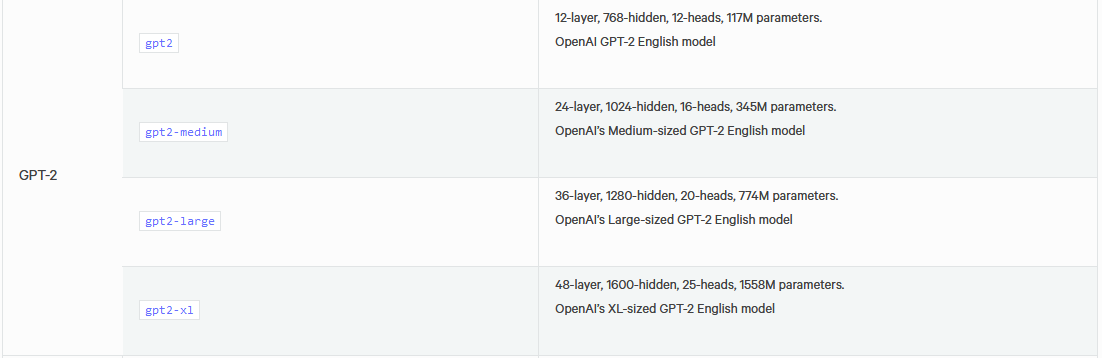


Given restrictions in compute power, **we will train only on the small GPT-2 model with 117MM parameters and the medium with 345MM parameters** (vs. large with 1280MM parameters). The extra large model with 1600MM was never released due to potentially harmful uses. 

We load a specific class of the GPT2 model, the **GPT2LMHeadModel**: it is a GPT2 Model transformer with a language modeling head on top (linear layer with weights tied to the input embeddings). It inherits its configuration from pretrainedModel; this is also where we load the weights from.

When using a pretrained model, it is **important to use the associated pretrained tokenizer** with it to ensure that it will split the text for the fine-tuning in the exact same way as the pretraining corpus and it will use the same correspondance token to index (vocab) as during pretraining. The GPT-2 tokenizer is based on **Byte-Pair-Encodings**. It detects the beginning of a word by the preceding space and has been trained to treat spaces like parts of the tokens  so a word will be encoded differently whether it is at the beginning of the sentence (without space) or not.



In [4]:
# Import GPT2 pretrained model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load pre-trained model (weights)
pretrained_weights = 'gpt2' #'gpt2-medium'

# Define tokenizer and model
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights, add_prefix_space=True)    # for documentation: https://huggingface.co/transformers/_modules/transformers/tokenization_gpt2.html

gpt2 = GPT2LMHeadModel.from_pretrained(pretrained_weights)   

In [5]:
# Set the model in evaluation mode to deactivate the DropOut modules, IMPORTANT to have reproducible results during evaluation!
gpt2.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

# 2. Generating a story using GPT-2 (Baseline)

We generate a story using the pre-trained GPT2 model (without fine-tuning it yet) as a baseline.

In [49]:
# Provided by evaluation/story-generator application
seed = "In a small village in the forest lived a boy with his cat and his dog."
max_len = 350

In [50]:
# Generate Output

seed = seed
max_len = max_len

my_model = gpt2
MAX_LEN = 100
TEMP = 0.9     # Temperature is used to control the randomness of predictions by scaling the logits before applying softmax (small (0.2): model is more confident but also more conservative, large( 1.0): more diversity but also more mistakes)
TOP_K = 40
TOP_P = 0.85
NUM_SEQ = 1


def gen_output(sample_outputs):
  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))

def gen_story(my_model, seed, max_len):

  # take input
  prompt_ids = tokenizer.encode(seed)
  inp = tensor(prompt_ids)[None].cuda() # un-do .cuda() if no GPU available
 
  # generate output
  sample_outputs = my_model.generate(
                              inp,
                              do_sample = True, 
                              max_length = MAX_LEN,     
                              temperature = TEMP,
                              top_k = TOP_K, 
                              top_p = TOP_P, 
                              num_return_sequences = NUM_SEQ,

  )

  # Print Output
  for i, sample_output in enumerate(sample_outputs):
    print("{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens = True)))
    return

In [51]:
# Run if RuntimeError: Input, output and indices must be on the current device 
device = "cuda:0"
gpt2 = gpt2.to(device)

In [52]:
# Generate output
my_model = gpt2                    # insert model for text generation

gen_story(my_model,seed,max_len)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   And it was, and I saw it was a nice chance of it, so he said,  ‘I wish you are very sorry.   'Oh, I'll tell you,' said Philip.   But we all talked to them when we had a nice breakfast.   It's a man.   But we shall have gone to the village with our own house.  ...


# 3. Fine-tuning GPT-2 with children stories

Next, we will fine-tune the loaded, pre-trained English GPT2-model with a children book corpus. The corpus consists of 3.4MB of hand-selected children stories from the [Gutenberg project](https://www.gutenberg.org/ebooks/bookshelves/search/?query=children%7Cchristmas%7Cchild%7Cschool) . We load the dataset, do some cleaning, before then tokenizing and numericalizing it using fastai library and loading it into a dataloader object. 

### 3.1 Preprocessing training text

In [5]:
## Import the data (one sentence per line)
#path = "/content/nlp_short_story_generator/data/input_stories_toddlerpluschildren.txt" #within cloned git repo

path = "/content/gdrive/MyDrive/NLP/data/stories/input_stories_toddlerpluschildren.txt"

string = []    
with open(path, "r") as f:
    full_text = f.read()
    for l in re.split(r"(\.)", full_text):
        if l != ".":
            string.append(l + ".")

df = pd.DataFrame(string).rename(columns = {0: "text"})
df.head()

,text
0,text\n A duck made her nest under some leaves.
1,\n She sat on the eggs to keep them warm.
2,"\n At last the eggs broke, one after the other."
3,\n Little ducks came out.
4,\n Only one egg was left.


In [6]:
# Clean text
def clean_text(df):
  df = df.drop(df[df["text"].str.isupper()].index)        # remove headlines and "THE END" - since written in uppercase letters
  df['text'] = df['text'].str.replace('\n', ' ')          # removes linebreaks \n and replaces it with whitespace
  df['text'] = df['text'].str.replace('_', ' ')
  df['text'] = df['text'].str.replace('--', ',')
  return df


df = clean_text(df)

df.sample(10)

,text
33738,"'Maybe I could if you'd let me take hold of your hand,' suggested Teddy."
8388,Two came up by the roots.
26175,No girl might go outside the pasture without special permission.
36138,"And a red ant came up, and very politely asked if she might not pick up the crumbs which the old rabbit dropped."
24553,"'Indeed!' Her neighbor was taking off her boots, and did not seem as much impressed as the occasion merited."
1453,"My foster-mother,' here he stopped and kissed Necile's white forehead, 'I shall love and cherish while life lasts."
465,"' So he went to Freyja and said, 'Will you let me have your falcon suit? I can get the hammer back if you will."
30400,"'It's easy enough to catch them,' said Polly; 'an hour after dawn they go to sleep, but it's unsportsmanlike to kill game when it's asleep."
16578,"The children hid the bath under the girls’ bed, and had supper."
277,I will get the apples for you.


In [7]:
# Split into test and train
from sklearn.model_selection import train_test_split

train_test_ratio = 0.9
#train_valid_ratio = 7/9
df_full_train, df_test = train_test_split(df, train_size = train_test_ratio, random_state = 1)
#df_train, df_valid = train_test_split(df_full_train, train_size = train_valid_ratio, random_state = 1)

### 3.2 Tokenize and numericalize training text

We will now build a Transform that will be applied lazily, using the **fastAI Tokenizer**. In a fastai transform we can define (among others): 
- an encodes method: applied when calling the transform (think: forward method in a neural net module)
- a decodes method: applied when calling the decode method of the transform, e.g. if anything needs to be decoded for showing purposes (converting ids to a text) [Source](https://medium.com/@pierre_guillou/faster-than-training-from-scratch-fine-tuning-the-english-gpt-2-in-any-language-with-hugging-f2ec05c98787)











In [8]:
# To process this data to train a model, we need to build a Transform that will be applied lazily.

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [9]:
# Test of the class TransformersTokenizer of fastai with tokenizer
tokenizer_fastai = TransformersTokenizer(tokenizer)
text = df.text[998]
tokens_ids = tokenizer_fastai.encodes(text)
tokens = tokenizer_fastai.tokenizer.convert_ids_to_tokens(tokens_ids)

print('input text:',TitledStr(text))
print('text tokens:',TitledStr(tokens))
print('text tokens_ids:',TitledStr(tokens_ids))
print('output text:',TitledStr(tokenizer_fastai.decodes(tokens_ids)))

input text:    Lucie ran on, and on.
text tokens: ['Ġ', 'Ġ', 'ĠLuc', 'ie', 'Ġran', 'Ġon', ',', 'Ġand', 'Ġon', '.']
text tokens_ids: tensor([ 220,  220, 7598,  494, 4966,  319,   11,  290,  319,   13])
output text:    Lucie ran on, and on.


Next, we are creating our **Dataset and Dataloader** using Transform and a TfmdList. Tfmd List contains the training and validation dataset, which we create with 'splits'. Since we are dealing with a Language Model, we specify dl_type= LMDataLoader when converting the TfmdLists (containing our train and validation data) to DataLoaders. The Fastai library expects its input as a DataLoader object, containing train and validation set.







In [10]:
# Creating Dataset and Dataloader
# We gather all texts in one numpy array (since it will be easier to use this way with fastai)
all_texts = np.concatenate([df_full_train["text"].values, df_test["text"].values])

# We define the split between training and validation data
splits = [range_of(df_full_train), list(range(len(df_full_train), len(all_texts)))]

# We create the tls [WIP - EXPLAIN WHAT TLS IS]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [11]:
tls.train[0],tls.valid[0]

(tensor([ 220,  220,  843,  788,  673,  447,  247,  297, 4117,  340,   11,  523,  326,  340,  220,  460,  447,  247,   83,  220, 5938, 2687,   13]),
 tensor([  220,   220,   679,  2497,   257,  1263, 16723,    13]))

In [12]:
show_at(tls.train, 345)

   Her temper, not always her strong point, displayed a degree of irritability that drove her family to the verge of mutiny.


Next, we need to specify the batch size and sequence length for the dataloaders object. 
We'll train with sequences of size 256 (GPT2 used sequence length 1024, but not everyone has enough GPU RAM for that) and batch size of 4 (a value higher gives a “CUDA out of memory error” on our single GPU).



In [13]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [14]:
dls.show_batch(max_n=2)

,text,text_
0,"'Then this really is an enchanted castle?' 'Of course it is,' said the Princess. Now he stood up and spoke. 'The wolf pulled the string and the door opened. 'You've gone out of your senses, you two! There ain't any gold there, only the poor child's hands, all over dirt, and like the very chimbley. Praise helps people very much, sometimes. I'll make you some. 'How could you say you were thinking about her all the time?' said a voice just by Gerald's ear, when Mademoiselle had left them alone with the bread and butter and milk and baked apples. ” “This is a HOT river, then,” said Phyllis; “lend a hand with the bath, there's a dear. Came over with the Conker, as the saying is. 'They ain't got no insides,'","'Then this really is an enchanted castle?' 'Of course it is,' said the Princess. Now he stood up and spoke. 'The wolf pulled the string and the door opened. 'You've gone out of your senses, you two! There ain't any gold there, only the poor child's hands, all over dirt, and like the very chimbley. Praise helps people very much, sometimes. I'll make you some. 'How could you say you were thinking about her all the time?' said a voice just by Gerald's ear, when Mademoiselle had left them alone with the bread and butter and milk and baked apples. ” “This is a HOT river, then,” said Phyllis; “lend a hand with the bath, there's a dear. Came over with the Conker, as the saying is. 'They ain't got no insides,' said"
1,"the Crowland Road. Board and lodging will be provided at the Provisional Palace where you slept last night. ’ ‘And we wished to ask you something else!’ said Oswald; and he made a sign to Alice to get the sherry ready in the glass. 'We might pull it over the snow, to be sure,' said Glossie; 'but we would not pull it fast enough to enable us to visit the far-away cities and villages and return to the Forest by daybreak. But I don't know how easy it's going to be to ferry him over. A rocking-horse as big as a pony, the finest dolls' house you ever saw, boxes of tea-things, boxes of bricks, both the wooden and the terra-cotta sorts, puzzle maps, dominoes, chessmen, draughts, every kind of toy or game that you have ever had or ever","Crowland Road. Board and lodging will be provided at the Provisional Palace where you slept last night. ’ ‘And we wished to ask you something else!’ said Oswald; and he made a sign to Alice to get the sherry ready in the glass. 'We might pull it over the snow, to be sure,' said Glossie; 'but we would not pull it fast enough to enable us to visit the far-away cities and villages and return to the Forest by daybreak. But I don't know how easy it's going to be to ferry him over. A rocking-horse as big as a pony, the finest dolls' house you ever saw, boxes of tea-things, boxes of bricks, both the wooden and the terra-cotta sorts, puzzle maps, dominoes, chessmen, draughts, every kind of toy or game that you have ever had or ever wished"


### 3.3 Train GPT-2 model with prepared training text (fine-tuning)

We can now use our prepared dataset (the dls) to fine-tune the pre-trained GPT-2 model. We will start with the default of fast.ai for most parameters.
If GPU is activated, we can make use of mixed precision by adding the fp16 flag (to save memory and speed up training time). 
To train, we will use language_model_learner: it automatically calls freeze when using a pretrained model (which is the default), so this will only train the embeddings (the only part of the model that contains randomly initialized weights—i.e., embeddings for words that are in our children books vocab, but aren't in the pretrained model vocab):



In [15]:
# We use callbacks in case we want to alter the behavior of the training loop 
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [18]:
gpt2.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [19]:
learn = Learner(dls, 
                gpt2, 
                loss_func=CrossEntropyLossFlat(), 
                cbs=[DropOutput],  #drop_mult=0.3, #             # Regularization
                metrics=[accuracy, Perplexity()]).to_fp16()   # Accuracy metric: to see how many times our model is right when trying to predict the next word, perplexity: exponential of the loss (i.e., torch.exp(cross_entropy))

In [20]:
# Check how good the model is doing without any fine-tuning step
learn.validate()

(#3) [3.974140167236328,0.30109626054763794,53.204349517822266]


Without any fine-tuning, our model has a train loss of 4.0, an accuracy of 30% and perplexity of 53. Let's make use of lr_find method to find the optimal learning rate for our model:



SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=0.00015848931798245758)

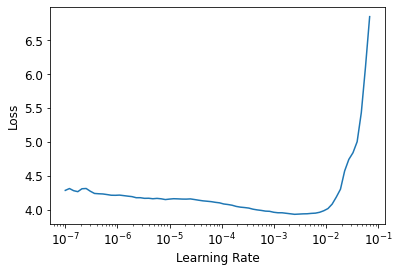

In [20]:
#learn.lr_find()

The result suggests to use a learning rate somewhere around 10^-3.

In [21]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.739712,4.691830,0.230622,109.052582,05:10


In [22]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.460530,4.460900,0.257137,86.565369,05:11


In [23]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.207485,4.221808,0.287259,68.156631,05:11


In [24]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.033895,4.096115,0.299424,60.106297,05:12


In [25]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.940936,4.013850,0.307810,55.359608,05:11


In [26]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.804417,3.965005,0.312504,52.720543,05:11


In [27]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.724388,3.934412,0.314788,51.132099,05:10


In [28]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.693527,3.911869,0.317967,49.992313,05:10


In [29]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.611609,3.897907,0.321148,49.299133,05:10


We made it! After 9 rounds of training (+ the initial validate), we achieved a **final validation loss of 3.9, an accuracy of 32% and a perplexity of 49**. We specifically ran each epoch of training separetly to ensure that we would not overtrain our model (like a manual attempt at early stopping) given that when previously training with a much smaller dataset, the model converged and thus overtrained extremely quickly, and due to previous memory issues with Colab's GPU. With the previously training on a smaller dataset we had achieved much better metrics (accuracy of 42%, perplexity of 21); however we believe that the smaller size of the dataset made correct predictions much easier but we are more interested in training with a large variety of stories to enhance the creativity of the generated text with our trained model. 

### 3.4 Save model

In [30]:
# https://fastai1.fast.ai/tutorial.inference.html

model_path = "/content/gdrive/MyDrive/NLP/data/models/"

learn.export(model_path + 'gpt2S_tuned_on_tandc.pkl')

### 3.5 Generate Shortstory with fine-tuned GPT-2 model

We can now generate text from our fine-tuned model.

In [34]:
# Load model

gpt2S_tuned_on_tandc = load_learner(model_path + 'gpt2S_tuned_on_tandc.pkl')

In [38]:
# Generate output
my_model = gpt2S_tuned_on_tandc                 # insert model for text generation

gen_story(my_model,seed,max_len)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   The people were so excited.   And at once it was a very good, but it was a big one of us.   And the girls followed the Psammead.   The learned gentleman was very busy with him.   They had got to find the Psammead, because they were not very much interested at all, and the others had gone and had to get...


# 4. Further Fine-tuning: Gradual unfreezing

Following: [Finetuning English GPT2 to any language](https://medium.com/@pierre_guillou/faster-than-training-from-scratch-fine-tuning-the-english-gpt-2-in-any-language-with-hugging-f2ec05c98787)
We will use two fastai v2 fine-tuning techniques: 
- Differential learning rates (a specific learning rate for each layers group)
- Gradual unfreezing (layers groups are defined allowing to decide the layers to be trained)

In [99]:
# Using a callback to alter the behavior of the training loop 
# (dropping some additional activations resulting from the hugging face model)

class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

#### (1) Splitter: getting the layer groups

The GPT2 model has 2 main layer (or parameter) groups:

- Transformer: 12 decorder blocks (attention heads) and their vocab embeddings and positioning
- 1 lm_head: a copy of the embeddings matrix wte (word token embeddings) to get the probability of each token in the vocab (using softmax)



In [100]:
gpt2

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [101]:
# Example of a decoder block (attention head)
gpt2.transformer.h[0]

Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

We will now split the transformer layers into separate blocks by creating 4 layers groups: 3 layers groups of 4 decoder blocks each and one embeddings groups with the wte (vocab embeddings) and wpe matrices (positioning embeddings).

In [102]:
# Split a GPT2 model in 4 groups for differential learning rates (Code from Finetuning English GPT2 to any language)

def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

#### (2) Creating our Learner 

Next, we create our learner for model training and inference, using our preprocessed input text (children stories), the pre-trained English GPT-2 (small/medium) as model, as well as the above defined callbacks and splitter definitions. 

In [103]:
# Create the learner (basic class for handling the training loop)
learn_tuned = Learner(dls, gpt2, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()])#.to_fp16()

In [104]:
# Check the number of parameters groups and the hyperparameters values
learn_tuned.create_opt()
print(f'number of parameters groups: {len(learn_tuned.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn_tuned.opt.hypers):
    print(i,h)


number of parameters groups: 4
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


In [105]:
# loss, accuracy, Perplexity() of validation dataset - without any fine-tuning
%%time
learn_tuned.validate()

CPU times: user 6.11 s, sys: 3.94 s, total: 10 s
Wall time: 10 s


(#3) [4.002852916717529,0.3271169364452362,54.75413513183594]

Without fine-tuning, our model shows:

- a loss of 4.0
- an accuracy of 32.7%
- a perplexity of 54.8



We will now use a range of **fine-tuning techniques**:

- **learning rate finder**: method that helps finding the best learning rate to train the model
- **Mixed precision training**: to speed up training, operations are split between FP16 and FP32
- **Gradual unfreezing**: using a model with several layers groups created (through splitter method)
- **1cycle policy with the method fit_one_cycle()**: "introduced by Leslie N. Smith et al. in Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates. It schedules the learning rate with a cosine annealing from lr_max/div to lr_max then lr_max/div_final (pass an array to lr_max if you want to use differential learning rates) and the momentum with cosine annealing according to the values in moms. The first phase takes pct_start of the training. You can optionally pass additional cbs and reset_opt."

- **Differential learning rates**: training each layers group with a different learning rate (the biggest LR for the embeddings group, the smallest one for the first 4 decoder blocks)[

[From](https://github.com/piegu/fastai-projects/blob/master/finetuning-English-GPT2-any-language-Portuguese-HuggingFace-fastaiv2.ipynb)



In [53]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   'I don't know what you're, but it's not a ring, and it's just as it does.   They were quite fast, though it had done.   'But it's a dreadful thing, and you'll be good and hungry.   ‘I’m not so glad to do anything to be brave and then, and you see.   ...


#### *(2.1) Freezing all layers but the last layers group (do not freeze wte, wpe embeddings matrices and last LayerNorm)*

In [106]:
learn_tuned.freeze()
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 768       
Embedding                                 38597376   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 2304      
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    23623

CPU times: user 16.2 s, sys: 12.9 s, total: 29.1 s
Wall time: 29.4 s


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.0005754399462603033)

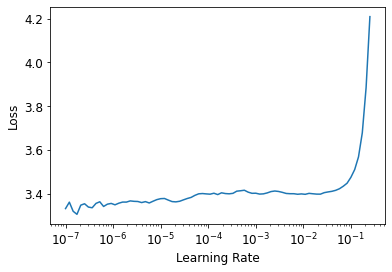

In [48]:
%%time
learn_tuned.lr_find()

We want to choose the learning rate that is not at the minimum, but one order of magnitude before the minimum to ensure that our learning rate is still improving the loss (and not making it worse). [Read more](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html://)
Admittingly, this is a bit tricky in this case so we decide to choose the learning rate at 10^-2, before the steep increase. 

In [107]:
learn_tuned.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.340025,3.954444,0.326636,52.166679,04:23


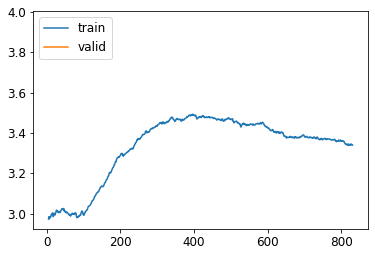

In [108]:
# Plotting training loss
learn_tuned.recorder.plot_loss()

In [57]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model_archive/"

learn_tuned.export(model_path + 'gpt2_1epoch_lr1e-2.pkl')

In [59]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   'Come on, Trouble!' cried Ted.   'You must have a little chance to be brave,' said Anthea.   “Yes,” said Robert, “but you don't believe anything in your mind, so we want to have him to go to it.   'If you're coming, you're invisible.   The wind of the tip of the...


#### *(2.2) Freezing all layers but the last 2 layers groups)*

In [109]:
learn_tuned.freeze_to(-2)
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 768       
Embedding                                 38597376   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 2304      
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    23623

In [110]:
# Discriminative-layer-training: https://forums.fast.ai/t/what-does-the-slice-lr-mean-in-fit-one-cycle/60896/5
learn_tuned.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3)) # Half of previous LR

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.187575,3.988175,0.327054,53.956310,04:39


epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	2.972569 	3.219555 	0.405902 	25.016983 	11:55

epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	3.017143 	3.222564 	0.404115 	25.092369 	11:55

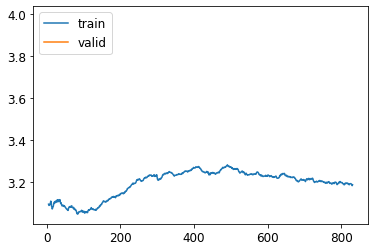

In [111]:
# Plotting training loss
learn_tuned.recorder.plot_loss()

In [76]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model_archive/"

learn_tuned.export(model_path + 'gpt2_2epoch_lr5e-3.pkl')

In [77]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   They were to be seen a band of a castle by the Sea.   'Well, I'm sorry,' said the Lord High Islander.   He looked, and he was just going to run away from the back door.   She said:,  “Look here,” said Bobbie, “and if she isn't.   He did not know what the...


#### *(2.3) Freezing all layers but the last 3 layers groups)*

In [112]:
learn_tuned.freeze_to(-3)
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 768       
Embedding                                 38597376   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 2304      
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    23623

In [113]:
learn_tuned.fit_one_cycle(1, slice(2.5e-3/(2.6**4),2.5e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.038076,4.040213,0.328411,56.838428,04:57


epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	2.271448 	3.098387 	0.420617 	22.162186 	12:51

epoch 	train_loss 	valid_loss 	accuracy 	perplexity 	time
0 	2.358402 	3.131221 	0.424981 	22.901917 	12:45

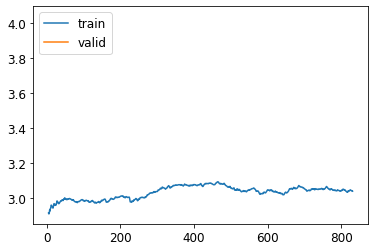

In [114]:
# Plotting training loss
learn_tuned.recorder.plot_loss()

In [94]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model_archive/"

learn_tuned.export(model_path + 'gpt2_3epoch_lr25e-3.pkl')

#learn_tuned = load_learner(model_path + 'gpt2_3epoch_lr25e-3.pkl')

In [96]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   The learned gentleman looked out at the moment in the glory of the big office, who had never yet seen the Phoenix to be seen, and it was a good sort of questions, and very interesting and beautiful, with an effort of a sort of money.   “What's the matter?” asked the Psammead, in his ear heart.   'I thought it wasn...


#### *(2.4) Unfreezing all layers*

In [115]:
learn_tuned.unfreeze()
learn_tuned.summary()

GPT2LMHeadModel (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 768       
Embedding                                 38597376   True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 2304      
Conv1D                                    1771776    True      
Conv1D                                    590592     True      
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     4 x 256 x 3072      
Conv1D                                    23623

In [116]:
learn_tuned.fit_one_cycle(2, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.910179,4.102807,0.328886,60.509903,05:10
1,2.843341,4.126224,0.329457,61.943584,05:09


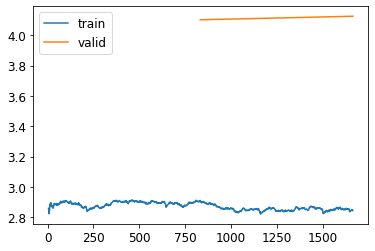

In [117]:
#hide
learn_tuned.recorder.plot_loss()

In [118]:
# Save model
model_path = "/content/gdrive/MyDrive/NLP/model_archive/"

learn_tuned.export(model_path + 'gpt2_5epoch_lr5e-4.pkl')

In [119]:
# Generate text
my_model = learn_tuned                # insert model for text generation

gen_story(my_model,seed,max_len) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0:  In a small village in the forest lived a boy with his cat and his dog.   She was very nice.   'I hope we've been looking, of course!' said the voice of Janet.   And I know they were in the world, and I saw it was not going to be very bad.   Then, after the giant found himself seated on his shoulders, and the children went down to the front gate.   Then the dragon and the door opened,...
